In [91]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams

from mlforecast import MLForecast
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM
from neuralforecast.auto import AutoLSTM

from src.data.loaders import CommodityLoader
from src.utils.split_series import split_series
from src.evaluation.evaluation import MetricEvaluator

In [92]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor':'#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 
}
plt.rcParams.update(dark_style)
rcParams['figure.figsize'] = (18,7)

In [93]:
df_brl = CommodityLoader.load_all_commodities(currency='BRL', preprocessing=True, monthly_aggregation='mean', limit_date=None)

ദ്ദി・ᴗ・)✧ acucar_santos carregado com sucesso
ദ്ദി・ᴗ・)✧ acucar_sp carregado com sucesso
ദ്ദി・ᴗ・)✧ algodao carregado com sucesso
ദ്ദി・ᴗ・)✧ arroz carregado com sucesso
ദ്ദി・ᴗ・)✧ cafe_arabica carregado com sucesso
ദ്ദി・ᴗ・)✧ cafe_robusta carregado com sucesso
ദ്ദി・ᴗ・)✧ milho carregado com sucesso
ദ്ദി・ᴗ・)✧ soja_parana carregado com sucesso
ദ്ദി・ᴗ・)✧ soja_paranagua carregado com sucesso
ദ്ദി・ᴗ・)✧ trigo_parana carregado com sucesso
ദ്ദി・ᴗ・)✧ trigo_rs carregado com sucesso


In [94]:
models = [
    MLPRegressor(
        hidden_layer_sizes=(64, 32),
        activation='relu',
        solver='adam',
        learning_rate_init=0.001,
        max_iter=500,
        random_state=42
    ),
    SVR(
        C=10.0,
        gamma=0.5,
        epsilon=0.25
    ),
    RandomForestRegressor(
        n_estimators=5,
        min_samples_leaf=5,
        max_depth=5,
    ),
    LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.1,
        max_depth=10,
        num_leaves=63,
        min_child_samples=5,
        reg_alpha=0,
        reg_lambda=0.01,
        random_state=42,
        verbose=-1
    ),
    XGBRegressor(
        n_estimators=50, 
        learning_rate=0.03125,
        reg_alpha=0, 
        reg_lambda=0.01,
        max_depth=6, 
        objective='reg:squarederror'
    )
]

fcst = MLForecast(
    models=models,
    lags=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    freq='MS'
)

In [95]:
def plot_single_series_and_forecasts(df_brl, forecasts_df, test_size):
    """
    Plota a série completa e as previsões de todos os modelos automaticamente.
    """
    uid = df_brl['unique_id'].unique()[0]  # pega o único valor existente
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 8))

    # Divide treino e teste
    series_data = df_brl.copy()
    train_data = df_brl.iloc[:-test_size].copy() if test_size else df_brl.copy()
    test_data = df_brl.iloc[-test_size:].copy() if test_size else pd.DataFrame()

    # Forecasts filtrados para essa série
    true_forecast = forecasts_df[forecasts_df['unique_id'] == uid].copy()

    # Série completa
    ax.plot(series_data['ds'], series_data['y'], 
            color='lime', linewidth=1.5, label='Série Completa')

    # Treino
    ax.plot(train_data['ds'], train_data['y'], 
            color='cyan', linewidth=2, label='Treino')

    # Teste real
    if not test_data.empty:
        ax.plot(test_data['ds'], test_data['y'], 
                color='fuchsia', linewidth=2, label='Teste (Real)')

    # Previsões
    ax.plot(true_forecast['ds'], true_forecast['MLPRegressor'], 
            color='red', linewidth=2, linestyle='--', label='Previsão MLPRegressor')

    ax.plot(true_forecast['ds'], true_forecast['SVR'], 
            color='blue', linewidth=2, linestyle='--', label='Previsão SVR')
    
    ax.plot(true_forecast['ds'], true_forecast['RandomForestRegressor'], 
            color='green', linewidth=2, linestyle='--', label='Previsão RandomForestRegressor')

    ax.plot(true_forecast['ds'], true_forecast['LGBMRegressor'], 
            color='pink', linewidth=2, linestyle='--', label='Previsão LGBMRegressor')
    
    ax.plot(true_forecast['ds'], true_forecast['XGBRegressor'], 
            color='yellow', linewidth=2, linestyle='--', label='Previsão XGBRegressor')

    # Linha vertical início teste
    if not test_data.empty:
        ax.axvline(x=test_data['ds'].iloc[0], color='orange', 
                  linestyle=':', alpha=0.8, linewidth=2, label='Início Teste')

    # Configurações do gráfico
    ax.set_title(f'Série Temporal e Previsões - {uid}', 
                fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Data', fontsize=12)
    ax.set_ylabel('Preço', fontsize=12)
    ax.legend(fontsize=10, loc='best')
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    print(f"Gráfico exibido para: {uid}")
    print("-" * 50)


=== Rodando Cross Validation para ACUCAR_SANTOS (Teste=20) ===


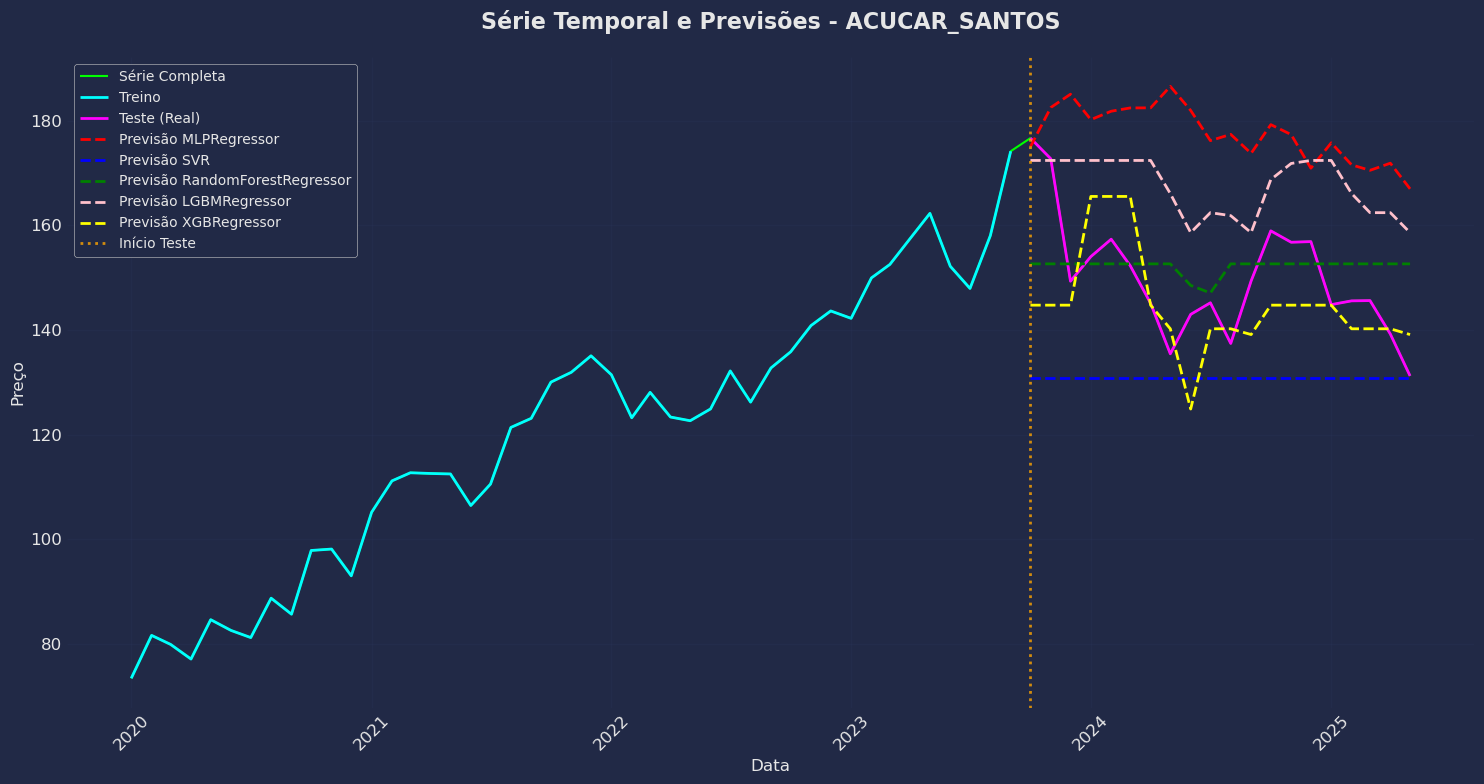

Gráfico exibido para: ACUCAR_SANTOS
--------------------------------------------------

=== Rodando Cross Validation para ACUCAR_SP (Teste=80) ===


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


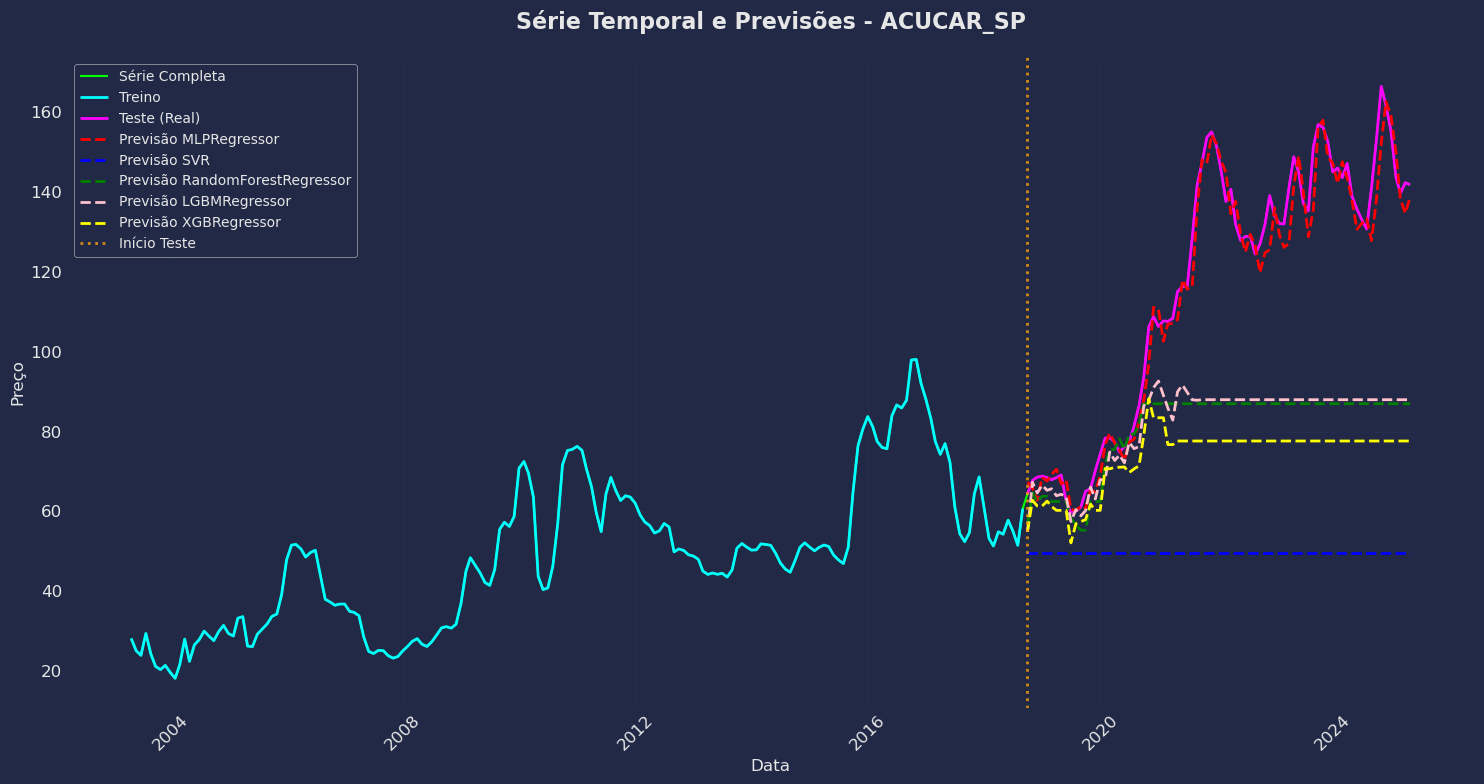

Gráfico exibido para: ACUCAR_SP
--------------------------------------------------

=== Rodando Cross Validation para ALGODAO (Teste=105) ===


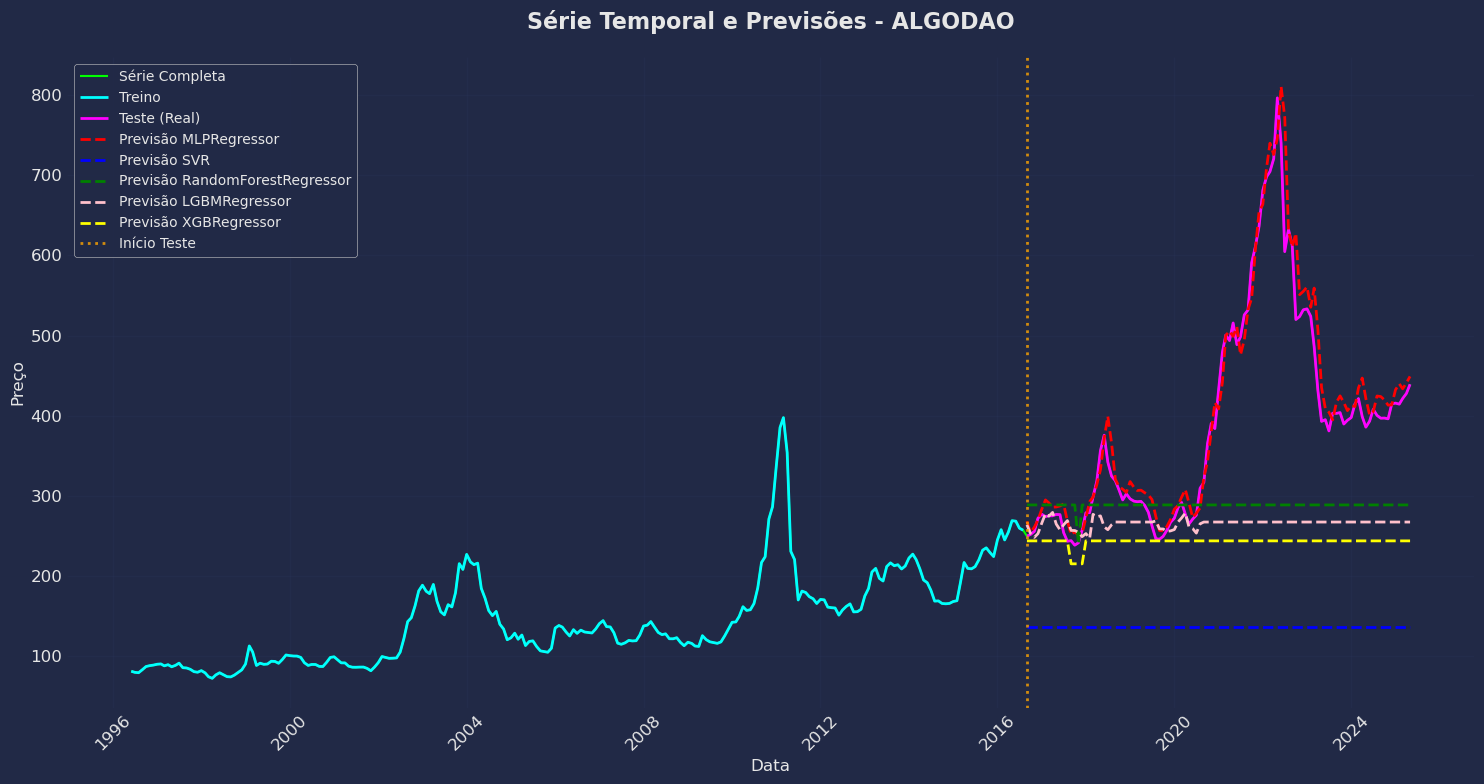

Gráfico exibido para: ALGODAO
--------------------------------------------------

=== Rodando Cross Validation para ARROZ (Teste=72) ===


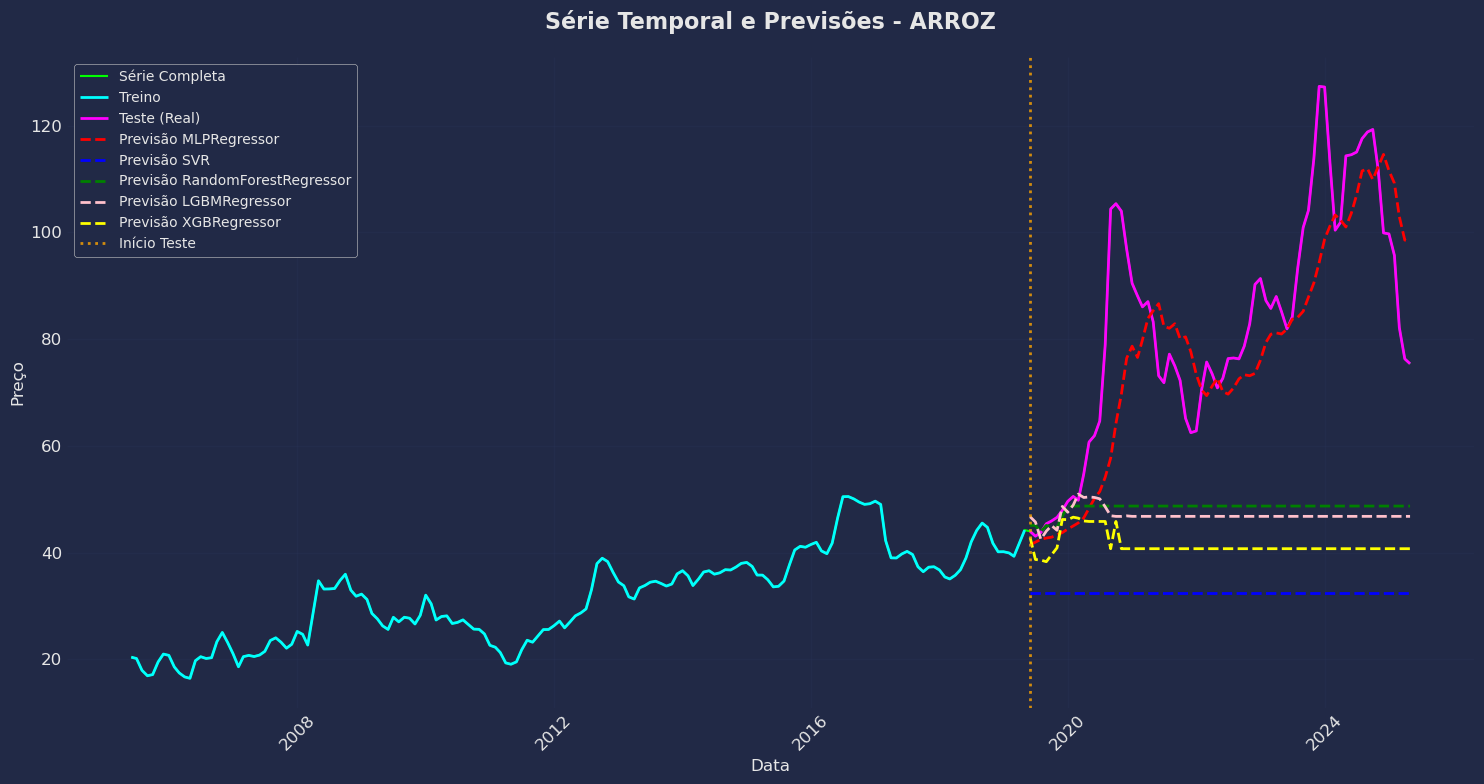

Gráfico exibido para: ARROZ
--------------------------------------------------

=== Rodando Cross Validation para CAFE_ARABICA (Teste=104) ===


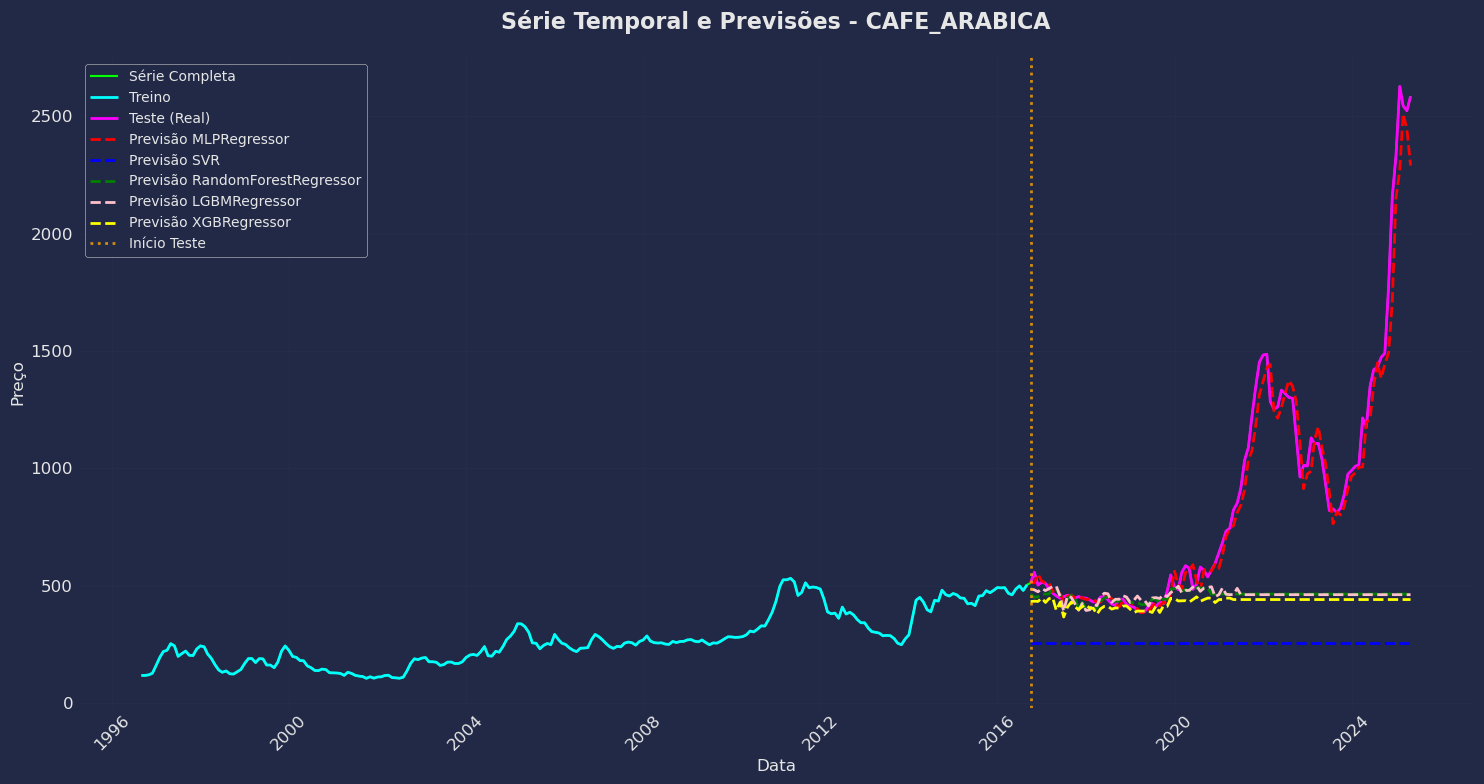

Gráfico exibido para: CAFE_ARABICA
--------------------------------------------------

=== Rodando Cross Validation para CAFE_ROBUSTA (Teste=87) ===


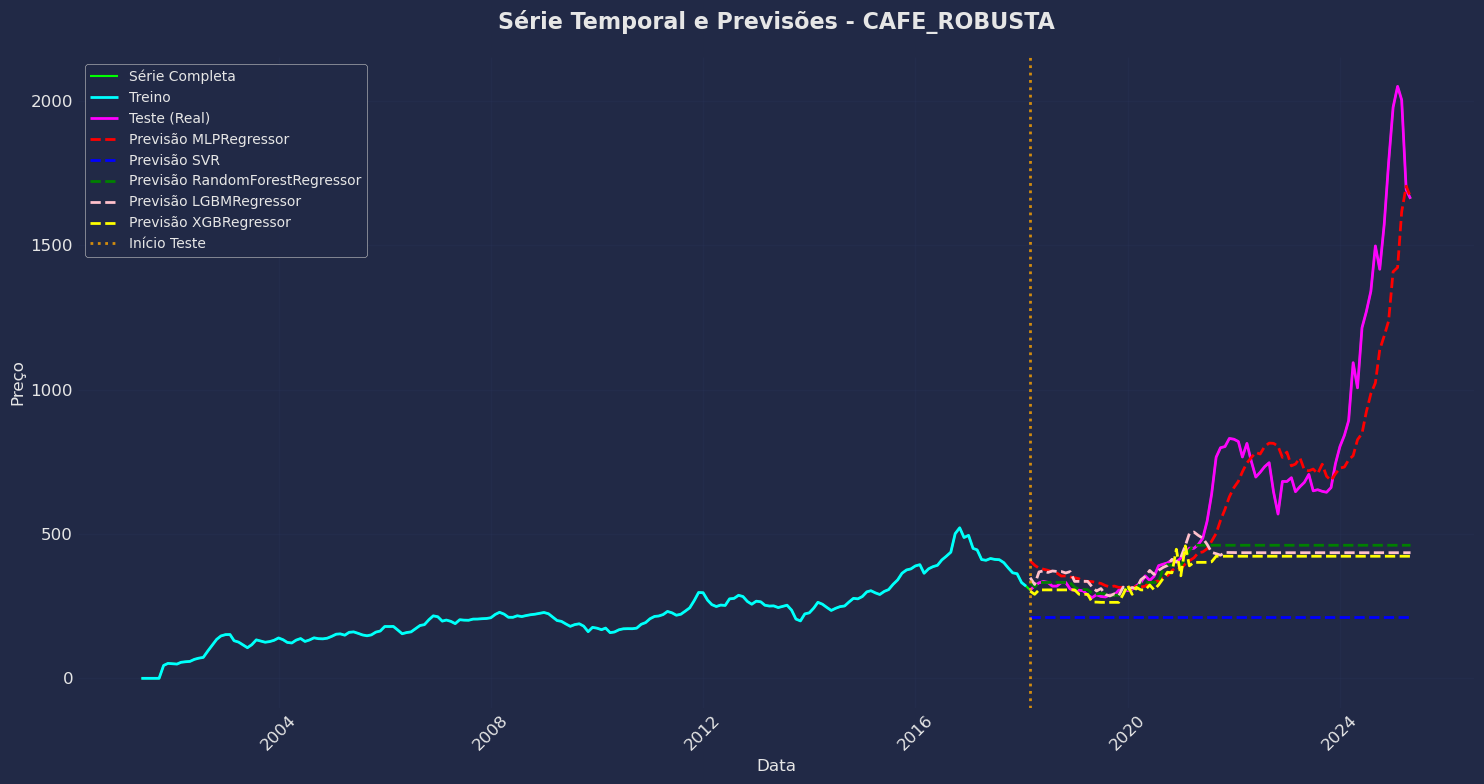

Gráfico exibido para: CAFE_ROBUSTA
--------------------------------------------------

=== Rodando Cross Validation para MILHO (Teste=75) ===


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


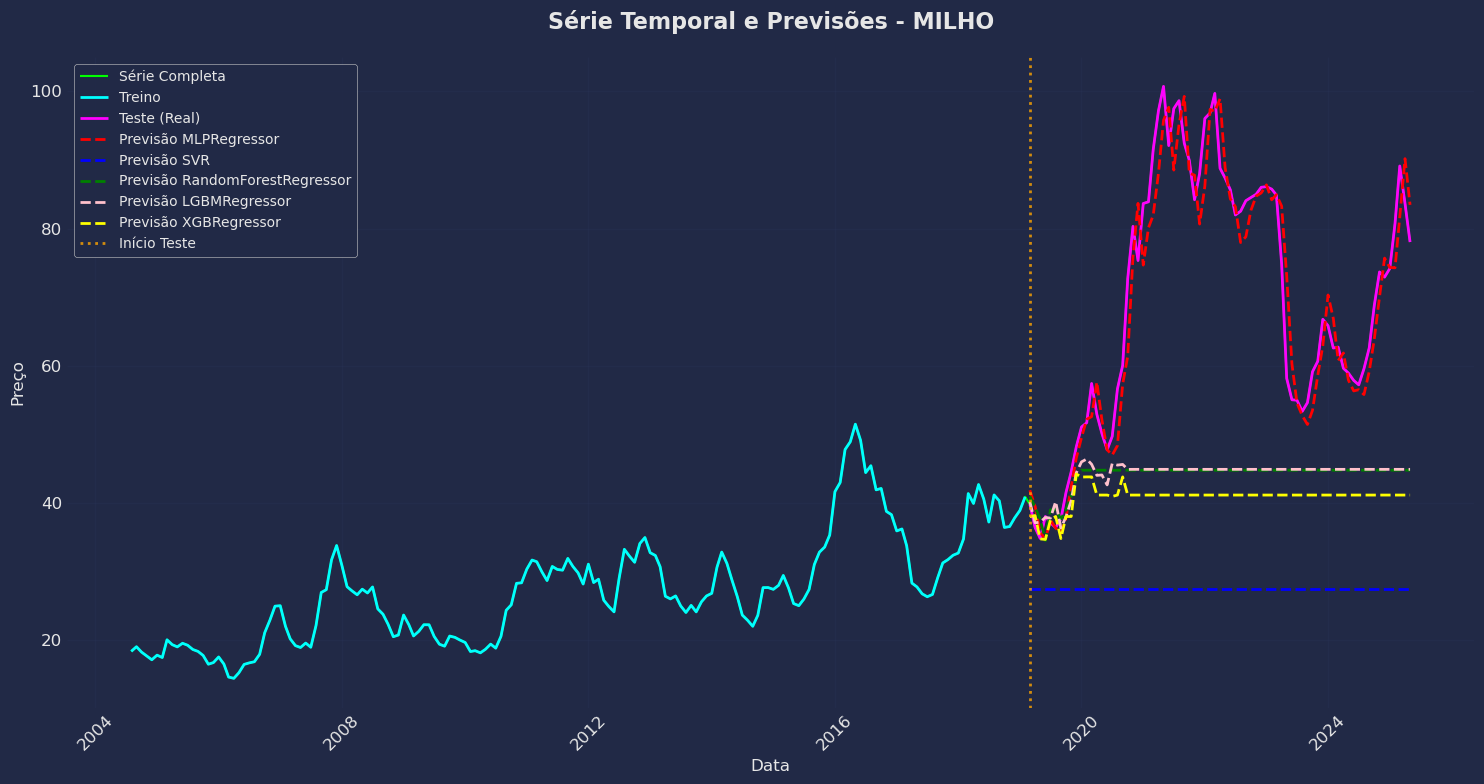

Gráfico exibido para: MILHO
--------------------------------------------------

=== Rodando Cross Validation para SOJA_PARANA (Teste=101) ===


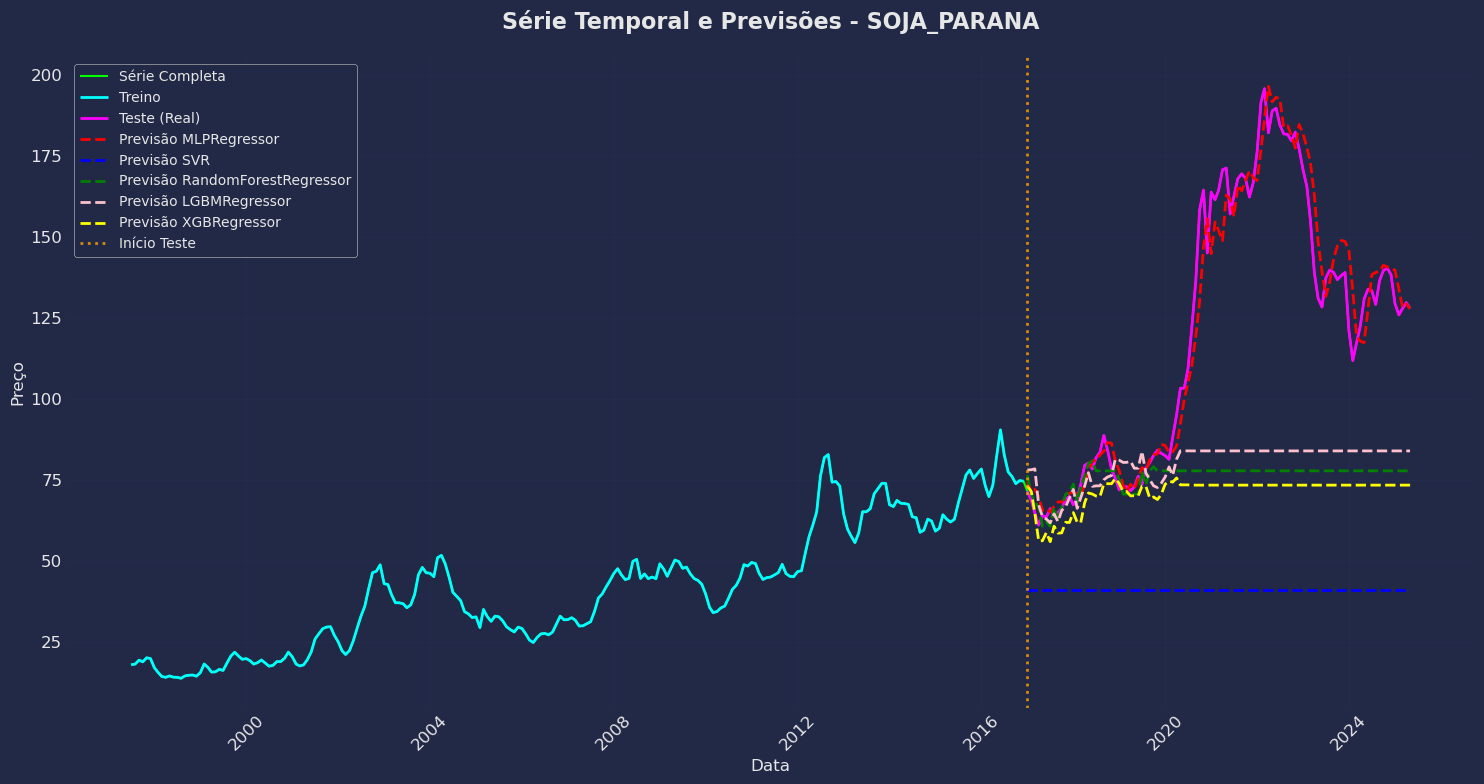

Gráfico exibido para: SOJA_PARANA
--------------------------------------------------

=== Rodando Cross Validation para SOJA_PARANAGUA (Teste=70) ===


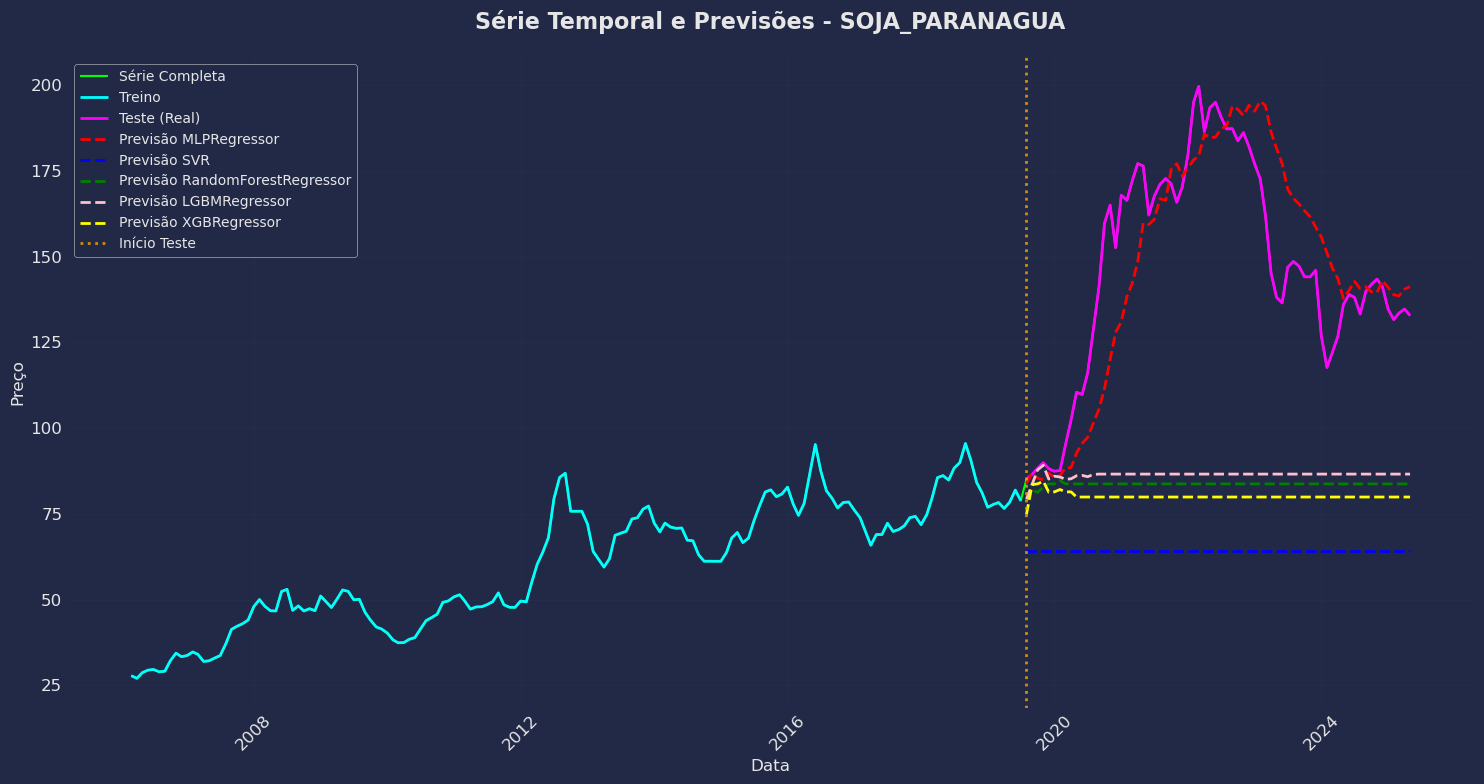

Gráfico exibido para: SOJA_PARANAGUA
--------------------------------------------------

=== Rodando Cross Validation para TRIGO_PARANA (Teste=77) ===


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


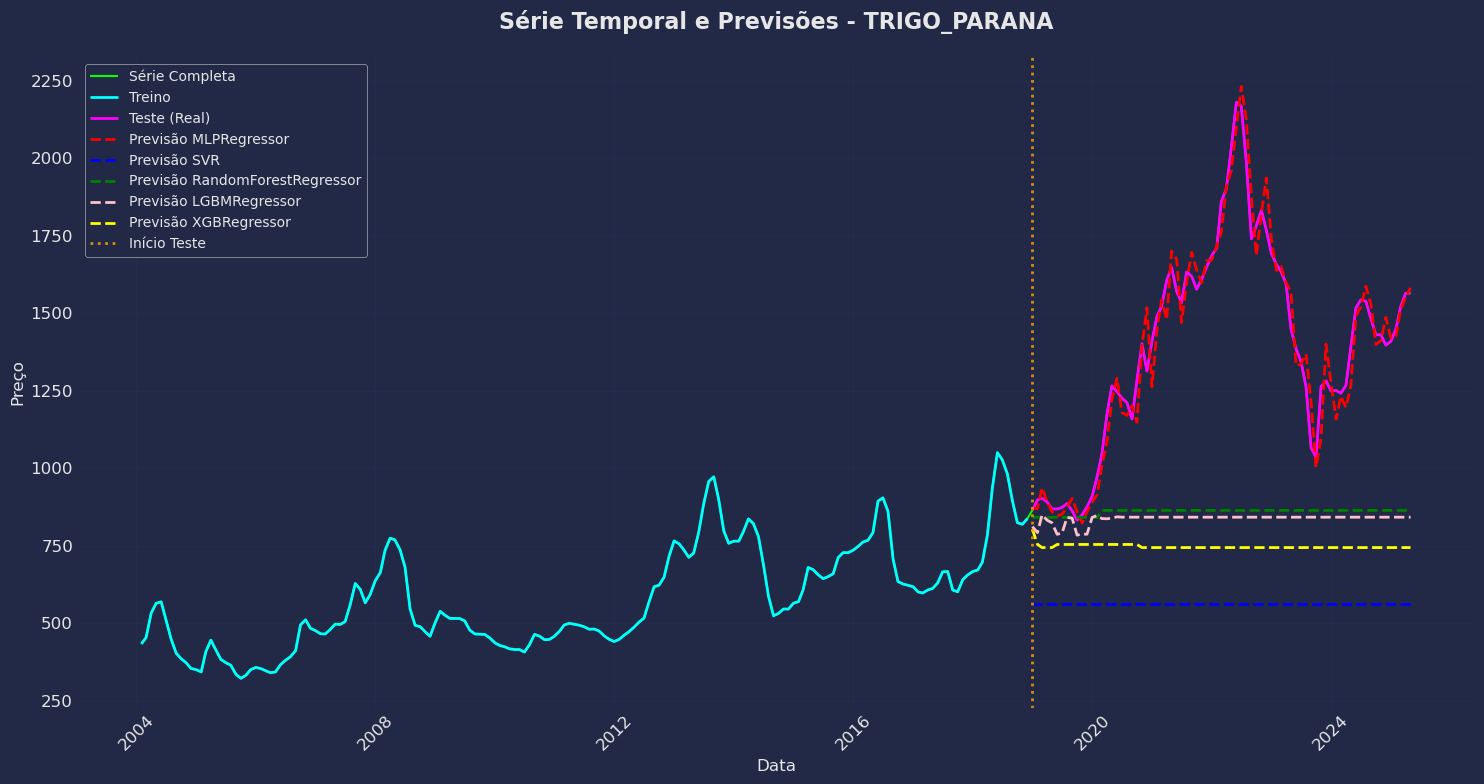

Gráfico exibido para: TRIGO_PARANA
--------------------------------------------------

=== Rodando Cross Validation para TRIGO_RS (Teste=77) ===


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


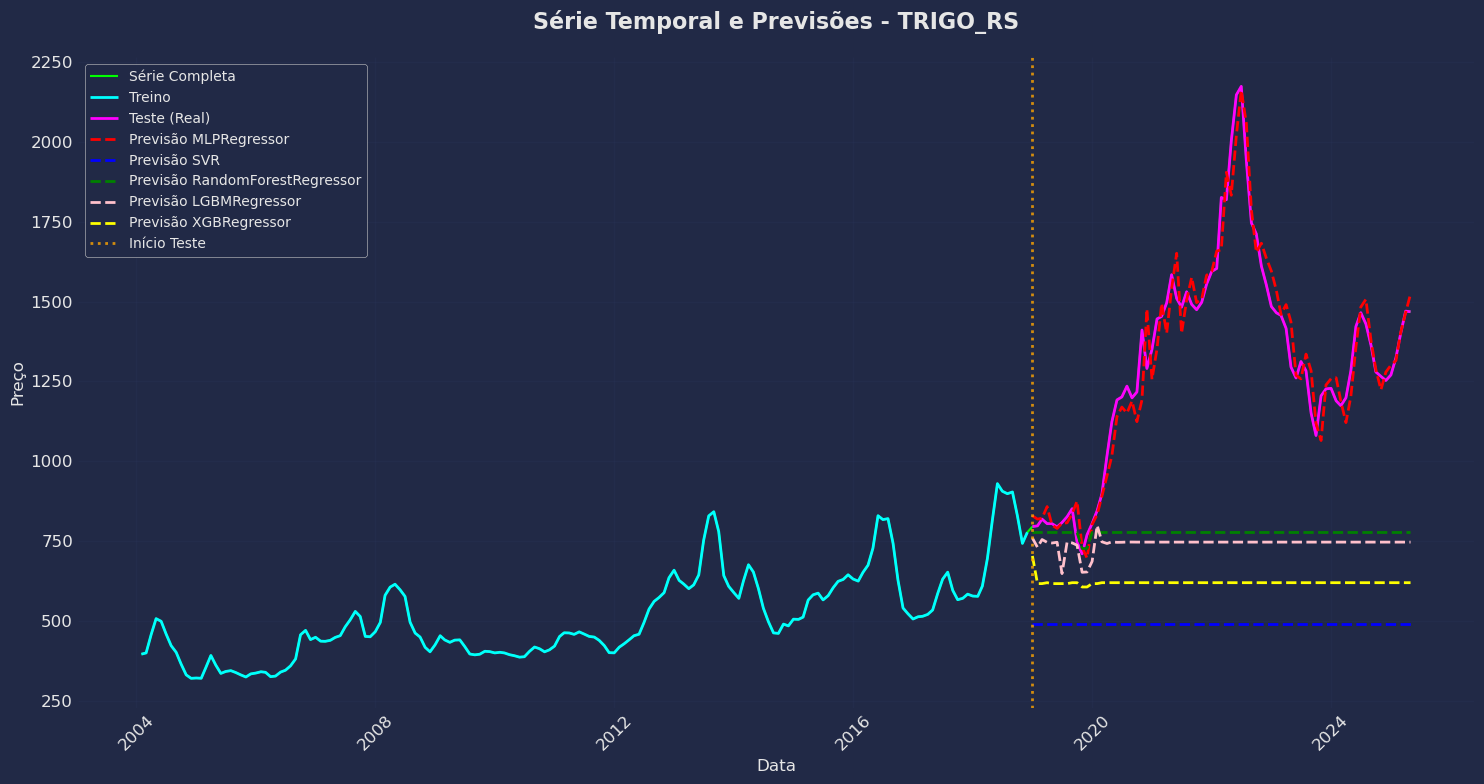

Gráfico exibido para: TRIGO_RS
--------------------------------------------------


In [96]:
series_test_sizes = {
    "ACUCAR_SANTOS": 20,
    "ACUCAR_SP": 80,
    "ALGODAO": 105,
    "ARROZ": 72,
    "CAFE_ARABICA": 104,
    "CAFE_ROBUSTA": 87,
    "MILHO": 75,
    "SOJA_PARANA": 101,
    "SOJA_PARANAGUA": 70,
    "TRIGO_PARANA": 77,
    "TRIGO_RS": 77
}

results = {}

for uid, test_size in series_test_sizes.items():
    print(f"\n=== Rodando Cross Validation para {uid} (Teste={test_size}) ===")
    
    df = df_brl[df_brl['unique_id'] == uid]
    
    cv_df = fcst.cross_validation(
        df=df,
        h=1,
        step_size=1,
        n_windows=test_size,
        fitted=True,
        refit=False
    )
    
    cv_fitted = fcst.cross_validation_fitted_values()
    # cv_fitted_clean = (
    #     cv_fitted.sort_values(["unique_id", "ds", "cutoff"])
    #              .drop_duplicates(subset=["unique_id", "ds"], keep="last")
    # )
    
    plot_single_series_and_forecasts(df, cv_df, test_size)
    
    results[uid] = {
        "cv_df": cv_df,
        # "cv_fitted_clean": cv_fitted_clean
    }


In [97]:
results['ACUCAR_SANTOS']['cv_df']

,unique_id,ds,cutoff,y,MLPRegressor,SVR,RandomForestRegressor,LGBMRegressor,XGBRegressor
0,ACUCAR_SANTOS,2023-10-01,2023-09-01,176.677619,175.022106,130.849119,152.641973,172.407422,144.750671
1,ACUCAR_SANTOS,2023-11-01,2023-10-01,172.731500,182.524723,130.849119,152.641973,172.407422,144.750671
2,ACUCAR_SANTOS,2023-12-01,2023-11-01,149.326842,185.072678,130.849119,152.641973,172.407422,144.750671
3,ACUCAR_SANTOS,2024-01-01,2023-12-01,154.029545,180.210218,130.849119,152.641973,172.407422,165.529892
4,ACUCAR_SANTOS,2024-02-01,2024-01-01,157.357368,181.815646,130.849119,152.641973,172.407422,165.529892
5,ACUCAR_SANTOS,2024-03-01,2024-02-01,152.284500,182.446785,130.849119,152.641973,172.407422,165.529892
6,ACUCAR_SANTOS,2024-04-01,2024-03-01,145.114091,182.464470,130.849119,152.641973,172.407422,144.750671
7,ACUCAR_SANTOS,2024-05-01,2024-04-01,135.445714,186.565788,130.849119,152.641973,166.084422,140.234375
8,ACUCAR_SANTOS,2024-06-01,2024-05-01,142.988000,181.964296,130.849119,148.530690,158.614953,124.900520
9,ACUCAR_SANTOS,2024-07-01,2024-06-01,145.203478,176.195927,130.849119,147.082418,162.428888,140.234375
